In [ ]:
#| default_exp cgm_plots

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
#| export

GLUC_COLOR = "C0"
DIET_COLOR = "brown"
SLEEP_COLOR = "purple"
FONTSIZE = 14


class CGMPlot:
    def __init__(
        self,
        cgm_df: pd.DataFrame,
        diet_df: Optional[pd.DataFrame] = None,
        cgm_date_col: str = "collection_timestamp",
        gluc_col: str = "glucose",
        diet_date_col: str = "collection_timestamp",
        diet_text_col: str = "shortname_eng",
        ax: Optional[plt.Axes] = None,
        smooth: bool = False,
        sleep_tuples: Optional[List[Tuple[pd.Timestamp, pd.Timestamp]]] = None,
    ) -> None:
        """
        Initialize a CGMPlot object.

        Args:
            cgm_df (pd.DataFrame): DataFrame containing the glucose measurements.
            diet_df (Optional[pd.DataFrame], optional): DataFrame containing the diet data. Defaults to None.
            cgm_date_col (str, optional): Name of the date column in cgm_df. Defaults to "Date".
            gluc_col (str, optional): Name of the glucose column in cgm_df. Defaults to "glucose".
            diet_date_col (str, optional): Name of the date column in diet_df. Defaults to "Date".
            diet_text_col (str, optional): Name of the text column in diet_df. Defaults to "shortname_eng".
            ax (Optional[plt.Axes], optional): Matplotlib Axes object to plot on. Defaults to None.
            smooth (bool, optional): Apply smoothing to the glucose curve. Defaults to False.
            sleep_tuples (Optional[List[Tuple[pd.Timestamp, pd.Timestamp]]], optional): List of sleep start and end times. Defaults to None.
        """
        self.cgm_df = cgm_df
        self.diet_df = diet_df
        self.cgm_date_col = cgm_date_col
        self.gluc_col = gluc_col
        self.diet_date_col = diet_date_col
        self.diet_text_col = diet_text_col
        self.smooth = smooth
        self.n_points = len(self.cgm_df[self.gluc_col])
        self.gluc_color = GLUC_COLOR
        self.diet_color = DIET_COLOR
        self.datetime_start = self.cgm_df[self.cgm_date_col].iloc[0]
        self.sleep_tuples = sleep_tuples

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(18, 5))
        self.ax = ax

    def prep_plot(self) -> None:
        """
        Prepare the plot by hiding the right and top spines.
        """
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)

    def plot_gluc(self) -> None:
        """
        Plot the glucose data.
        """
        ax = self.ax
        y = self.cgm_df[self.gluc_col]
        x = self.cgm_df[self.cgm_date_col]
        if self.smooth:
            # smoothing
            smoothed = (
                self.cgm_df.set_index(self.cgm_date_col)
                .asfreq(freq="60S")
                .interpolate(method="cubicspline")
            )
            ax.plot(
                smoothed.index,
                smoothed[self.gluc_col],
                ls="-",
                lw=4,
                color=self.gluc_color,
                alpha=0.8,
                )
        else:
            ax.plot(x, y, ls="-", lw=4, color=self.gluc_color, alpha=0.9)
        ax.scatter(x, y, s=60, color=self.gluc_color, alpha=0.6, label="Glucose")

    def plot_diet(self) -> None:
        """
        Plot the diet data.
        """
        ax = self.ax
        x_offset = pd.to_timedelta(-5, "minutes")
        max_y = ax.get_ylim()[1]
        min_y = ax.get_ylim()[0]
        ax.set_ylim(min(60, min_y), max(150, max_y))

        for i, (food_datetime, group) in enumerate(
            self.diet_df.groupby(self.diet_date_col)
        ):
            food_str = "\n".join(group[self.diet_text_col])

            txt_x = food_datetime - pd.to_timedelta(7.5, "m")
            if i % 2 == 0:
                txt_y = max(150, max_y) + 1
                horizontalalignment = "center"
            else:
                txt_y = max(150, max_y) + 5
                horizontalalignment = "center"

            ax.axvline(food_datetime, color=self.diet_color, alpha=0.5, ls=":")
            ax.scatter(
                x=food_datetime,
                y=max(150, max_y) - 2,
                marker="v",
                s=100,
                color=self.diet_color,
            )
            ax.text(
                x=txt_x,
                y=txt_y,
                s=(food_str),
                color=self.diet_color,
                horizontalalignment=horizontalalignment,
                fontsize=10,
            )

    def plot_sleep(self) -> None:
        """
        Plot the sleep data.
        """
        ax = self.ax
        for sleep_start, sleep_end in self.sleep_tuples:
            ax.fill_between(
                [sleep_start, sleep_end],
                ax.get_ylim()[0],
                ax.get_ylim()[1],
                color=SLEEP_COLOR,
                alpha=0.05,
            )

    def plot(self) -> None:
        """
        Plot the CGMPlot object.
        """
        self.prep_plot()
        self.plot_gluc()
        if self.diet_df is not None:
            self.plot_diet()
        if self.sleep_tuples is not None:
            self.plot_sleep()


In [ ]:
cgm_df= pd.read_parquet("./examples/cgm/cgm.parquet")
cgm_df.head()

glucose
participant_id collection_timestamp      connection_id         
0              2020-05-25 10:48:00+03:00 1000001          111.6
               2020-05-25 11:03:00+03:00 1000001           79.2
               2020-05-25 11:18:00+03:00 1000001           84.6
               2020-05-25 11:33:00+03:00 1000001          106.2
               2020-05-25 11:48:00+03:00 1000001          102.6

In [ ]:
diet_df = pd.read_parquet("./examples/diet_logging/diet.parquet")
diet_df.head()

collection_timestamp  food_id  weight  \
participant_id cohort                                              
0              10k    2020-05-25 08:15:00+03:00  1007294    40.0   
               10k    2020-05-25 08:15:00+03:00  1007417    87.0   
               10k    2020-05-25 08:15:00+03:00  1008624     6.0   
               10k    2020-05-25 08:15:00+03:00  1011642    12.0   
               10k    2020-05-25 10:05:00+03:00  1007118   100.0   

                       shortname_eng  
participant_id cohort                 
0              10k            Coffee  
               10k     Yellow Cheese  
               10k           Almonds  
               10k       Brazil nuts  
               10k            Hummus

In [ ]:
start_date = pd.to_datetime('2020-05-25',utc=True)
end_date = pd.to_datetime('2020-05-27',utc=True)

sample_days = cgm_df[(cgm_df.index.get_level_values('collection_timestamp') >= start_date) \
                     & (cgm_df.index.get_level_values('collection_timestamp') <= end_date)]

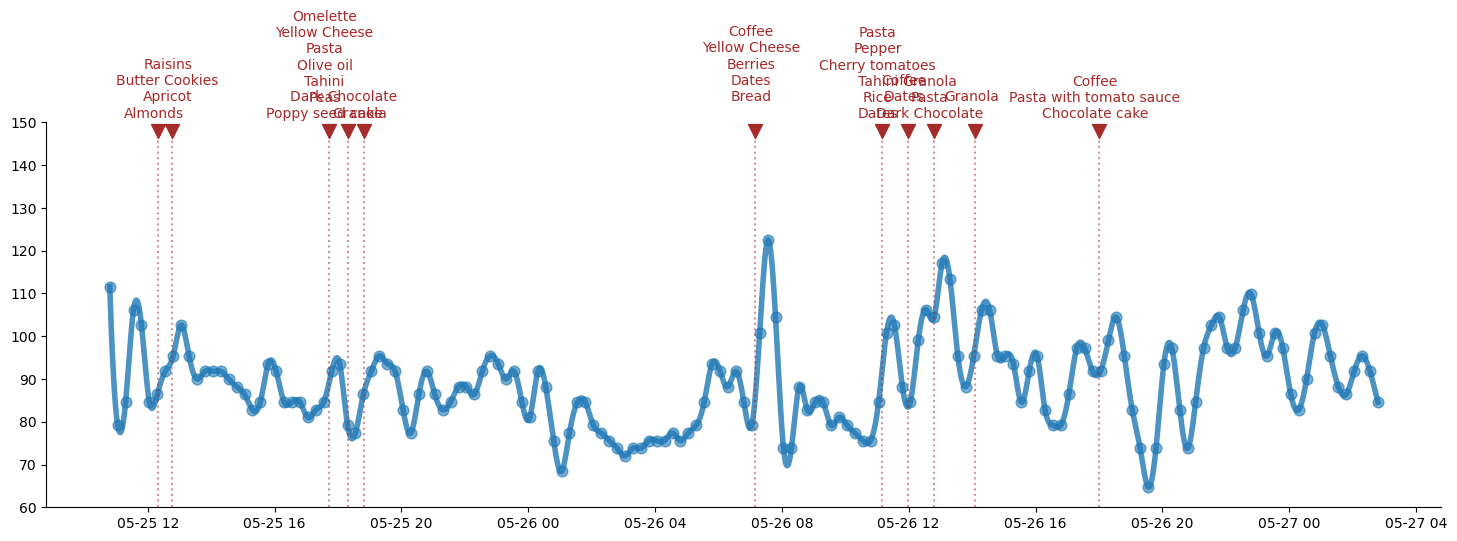

In [ ]:
cgmplt = CGMPlot(cgm_df=sample_days.reset_index(),
                 cgm_date_col="collection_timestamp",
                 gluc_col="glucose",
                 diet_df=diet_df.iloc[9:],
                 diet_date_col="collection_timestamp",
                 smooth=True)
cgmplt.plot()

# AGP

In [ ]:
#| export

class AGP:
    def __init__(
        self,
        cgm_df: pd.DataFrame,
        cgm_date_col: str = "collection_timestamp",
        gluc_col: str = "glucose",
        ax: Optional[plt.Axes] = None,
    ) -> None:
        """
        Initialize an AGP object.

        Args:
            cgm_df (pd.DataFrame): DataFrame containing the glucose measurements.
            cgm_date_col (str, optional): Name of the date column in cgm_df. Defaults to "collection_timestamp".
            gluc_col (str, optional): Name of the glucose column in cgm_df. Defaults to "glucose".
            ax (Optional[plt.Axes], optional): Matplotlib Axes object to plot on. Defaults to None.
        """
        self.cgm_df = cgm_df
        self.cgm_date_col = cgm_date_col
        self.gluc_col = gluc_col
        self.gluc_color = GLUC_COLOR

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(18, 5))
        self.ax = ax

        agp_df = (
            cgm_df.set_index(cgm_date_col)
            .asfreq(freq="60S")
            .interpolate(method="cubicspline")
            .reset_index()
        )
        agp_df["minute_in_day"] = 60 * agp_df[self.cgm_date_col].dt.hour + agp_df[self.cgm_date_col].dt.minute
        self.agp_df = agp_df

    def plot(self) -> None:
        """
        Plot the AGP object.
        """
        ax = self.ax
        agp_df = self.agp_df
        median = agp_df.groupby("minute_in_day")["glucose"].median()
        lo_5 = agp_df.groupby("minute_in_day")["glucose"].quantile(0.05)
        hi_95 = agp_df.groupby("minute_in_day")["glucose"].quantile(0.95)
        lo_25 = agp_df.groupby("minute_in_day")["glucose"].quantile(0.25)
        hi_75 = agp_df.groupby("minute_in_day")["glucose"].quantile(0.75)

        ax.plot(median, color="k", lw=3)
        ax.fill_between(median.index.values, lo_25, hi_75, color="navy", alpha=0.3)
        ax.fill_between(median.index.values, lo_5, hi_95, color="navy", alpha=0.1)

        xticks = [m for m in median.index.values if m % 180 == 0]
        xticks += [24 * 60]
        xticklabels = [f"{int(m/60)}:00" for m in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_ylabel("Glucose (mg\dL)", fontsize=14)

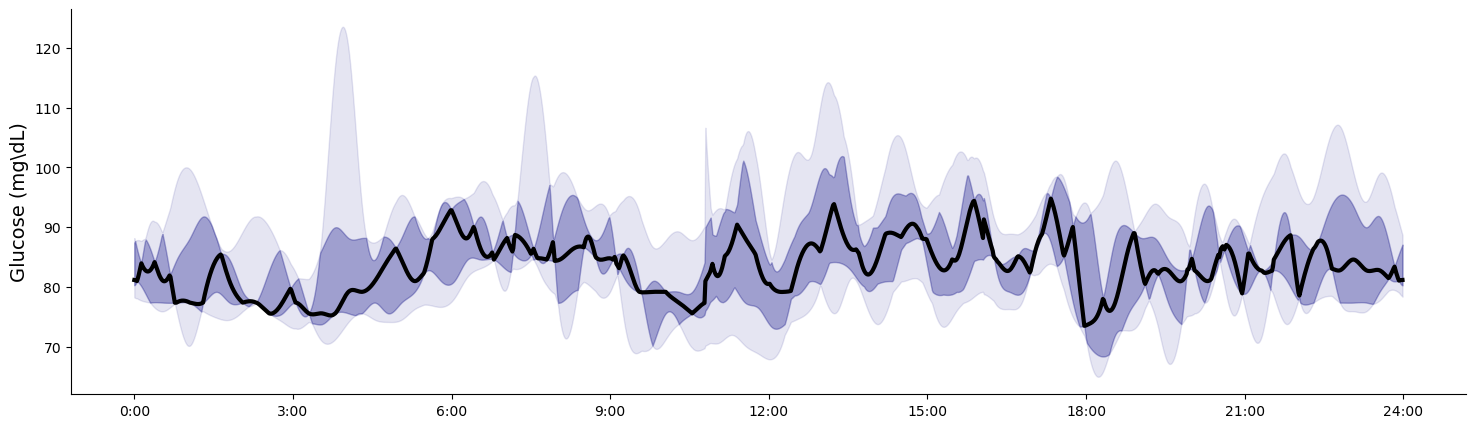

In [ ]:
agp = AGP(cgm_df=cgm_df.reset_index(), cgm_date_col="collection_timestamp", gluc_col="glucose")
agp.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()